<a href="https://colab.research.google.com/github/jesusllorens79/5154/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = (10, 6)

matplotlib.rcParams['text.color'] = 'k'

In [90]:
daily_sales = pd.read_excel('Exercise - Daily Sales - FOR CANDIDATE-SENT - SHORT.xlsx', sheet_name = 1, 
                            parse_dates=['Posting Date'])

Necesita generar una primera previsión para las ventas de todo el mes de noviembre de 2017 el 15 de noviembre (el 15 de noviembre es un día laborable). Para esta previsión a partir del 15 de noviembre, no puede utilizar el valor de las ventas diarias del 16 de noviembre o posteriores, ya que obviamente no habrían estado disponibles a partir del 15 de noviembre (

In [91]:
daily_sales.tail()

,Country,Posting Date,Brand,Daily Sales
629,Country 1,2018-02-14,Brand A,11305.37152
630,Country 1,2018-02-19,Brand A,25179.30168
631,Country 1,2018-02-20,Brand A,13206.75222
632,Country 1,2018-02-21,Brand A,10384.84878
633,Country 1,2018-02-23,Brand A,20.41332


In [92]:
cols=['Country', 'Brand']
daily_sales = daily_sales.drop(cols, axis = 1)
daily_sales = daily_sales.set_index('Posting Date')

In [93]:
daily_sales.head()

,Daily Sales
Posting Date,
2015-02-01,30785.21560
2015-05-01,18256.02366
2015-06-01,24168.04468
2015-07-01,3858.64932
2015-12-01,1229.33310


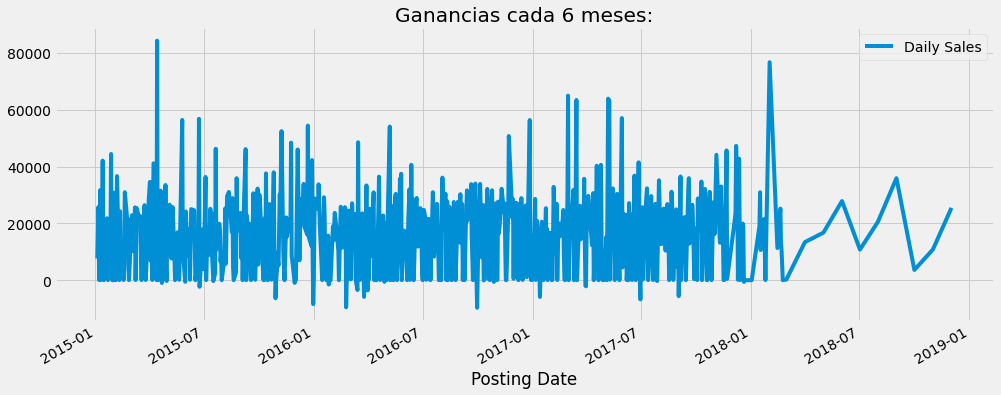

In [94]:
gan = daily_sales.plot(figsize=(15, 6), title='Ganancias cada 6 meses:')

In [95]:
daily_sales_perD = daily_sales.resample("D").sum()
#daily_sales_days.fillna(daily_sales_days["Daily Sales"].min(),inplace=True)
daily_sales_perD.head()

,Daily Sales
Posting Date,
2015-01-04,7676.84934
2015-01-05,0.00000
2015-01-06,25785.81652
2015-01-07,67.01334
2015-01-08,0.00000


In [96]:
#Make the first dataframe of November from 01 to 15:
daily_sales_nov=daily_sales_perD.loc['2017-11-01':'2017-11-15']
daily_sales_nov.head()

,Daily Sales
Posting Date,
2017-11-01,16209.75284
2017-11-02,0.00000
2017-11-03,0.00000
2017-11-04,44108.84254
2017-11-05,0.00000


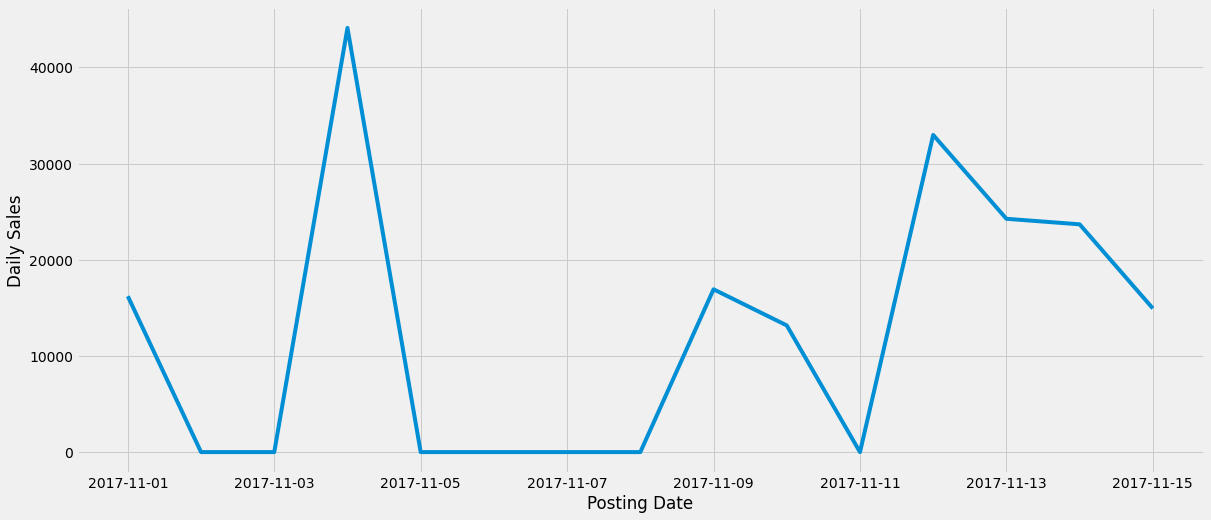

In [97]:
rcParams['figure.figsize'] = 18, 8
plt.xlabel("Posting Date")
plt.ylabel("Daily Sales")
plt.plot(daily_sales_nov)

Vemos que hay una tendencia que no es lineal, tiene sus picos a veces aumenta y luego desciende. No es estacionaria porque la media no es constante. A priori no hay una covarianza, osea las variables no están relacionadas.

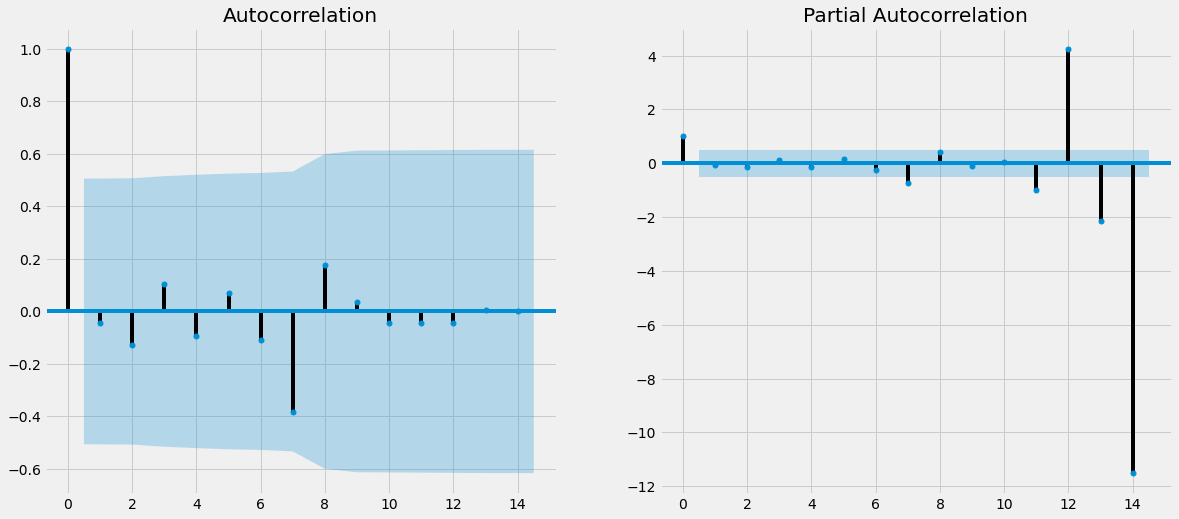

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(daily_sales_nov, lags=14, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(daily_sales_nov, lags=14, ax=ax2)
plt.show()

ACF ==>q = 0, porque el primer elemento es el de la autocorrelación consigo mismo, Q sería 0 porque no hay ningun valor despues de un ciclo y que además sobre salga; d = 1 porque los datos son estacionarios;

PACF ==> p y P, p=1

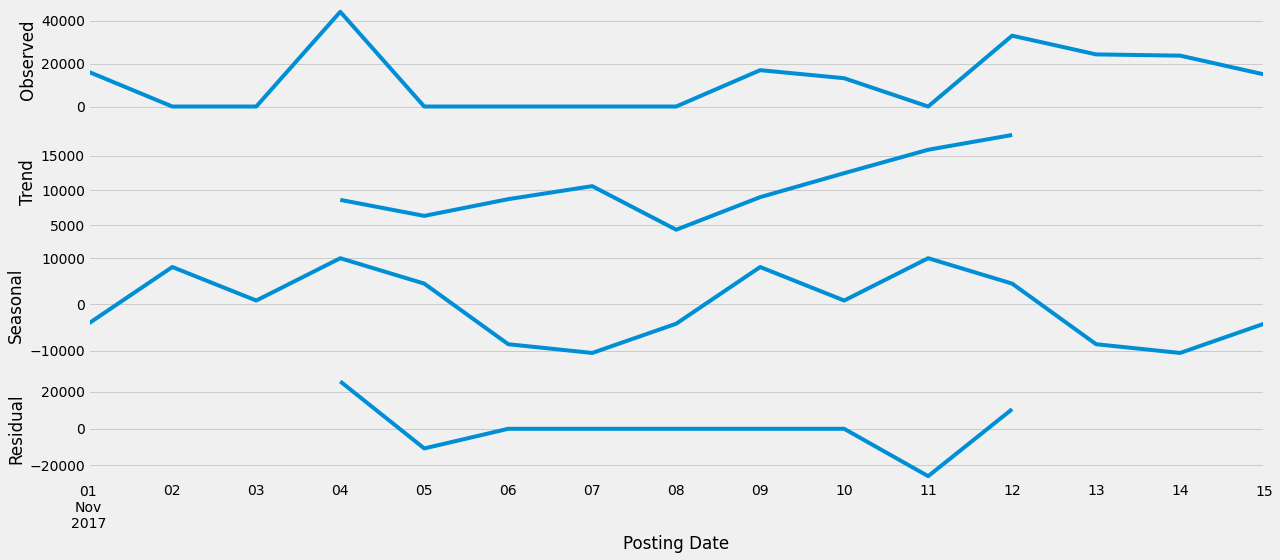

In [99]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(daily_sales_nov, model='additive', freq=7)
fig = decomposition.plot()

- The trend is incremental with the days.
- Hay estacionalidad, bastante consistente a lo largo de los dias. Ya sabemos que la frecuencia es 8 pero veremos como estimarla más adelante
- El término de ruido parece tener una varianza diferente, **tendremos que realizar una transformación** 

We can only plot 6 lags in Partial Autocorrelation, another prove that the time series is pretty clearly not stationary, so that Yule-Walker assumptions are violated.

# Transformar los datos para convertir la serie en estacionaria

In [100]:
from numpy import inf

#Lo primero que podemos hacer es aplicarle la transformación más usada (la logarítmica)
logy = np.log(daily_sales_nov)

#Then differencing to remove trends
logy[logy == -inf] = 0

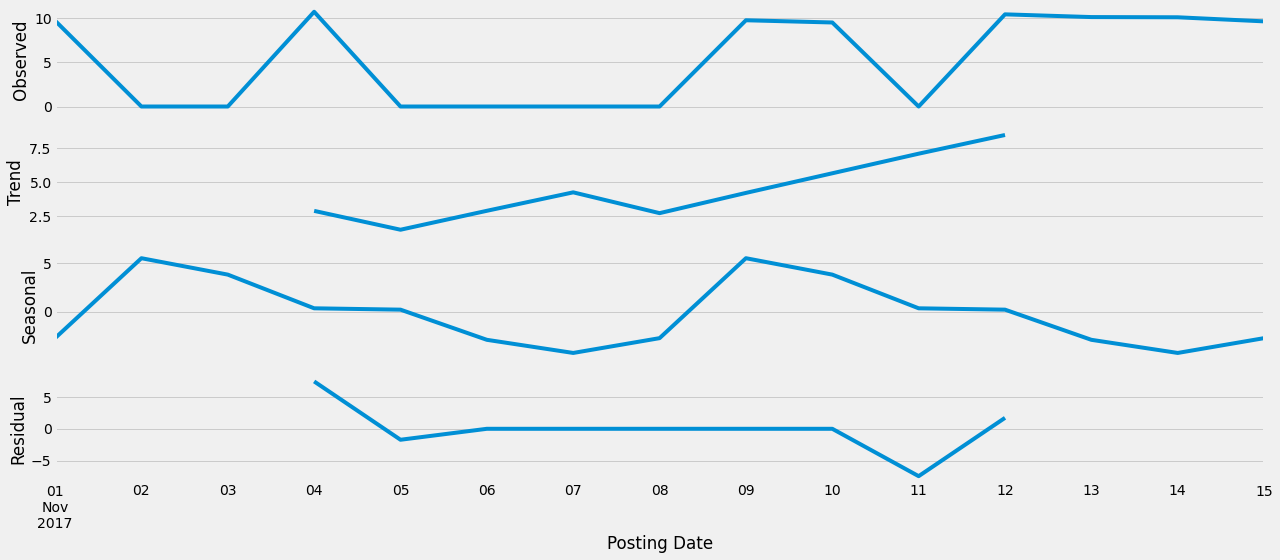

In [101]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(logy, model='additive')
fig = decomposition.plot()

Hay una tendencia clara, las ganancias han ido aumentando a lo largo de los dias. Tendremos que realizar la diferenciación.
Hay estacionalidad, bastante consistente a lo largo de los años. Frecuencia de 8.

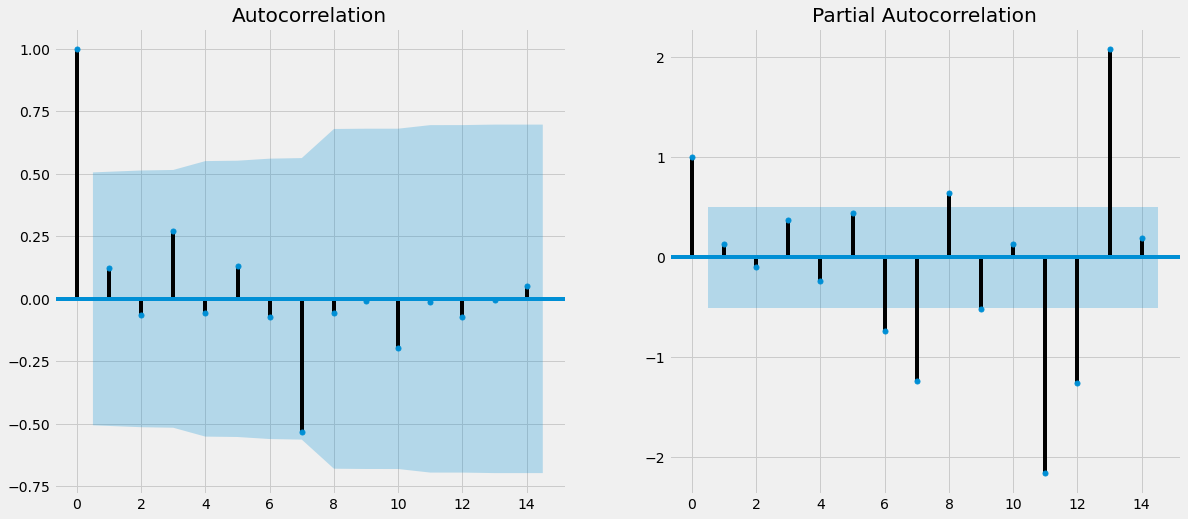

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(logy, lags=14, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(logy, lags=14, ax=ax2)
plt.show()

In [103]:
import itertools
def grid_search(y, pdq, seasonal_pdq):

    warnings.filterwarnings("ignore")
    aic = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                name = param+param_seasonal
                aic[name] = results.aic
                #print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Finding Best Parameter combinations for Seasonal ARIMA...')

aic = grid_search(logy, pdq, seasonal_pdq)
#get the model with minimum aic : min(dict, key=dict.get) will return the key with minimum value in dict
print("Model with Minimum AIC of {} is {}".format(aic[min(aic, key=aic.get)], min(aic, key=aic.get)))

Finding Best Parameter combinations for Seasonal ARIMA...
Model with Minimum AIC of -17.187973863531113 is (0, 0, 0, 1, 1, 0, 7)


In [104]:
mod = sm.tsa.statespace.SARIMAX(logy,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.9916   1.91e-20   -5.2e+19      0.000      -0.992      -0.992
sigma2          1e-10   1.98e-09      0.050      0.960   -3.78e-09    3.98e-09


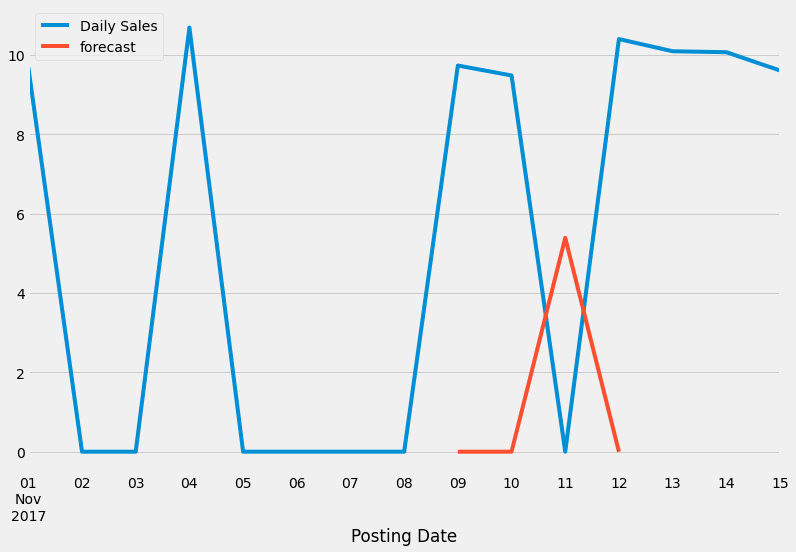

In [105]:
logy['forecast']=results.predict(start=8, end=11, dynamic=True)
logy[['Daily Sales','forecast']].plot(figsize=(12,8))

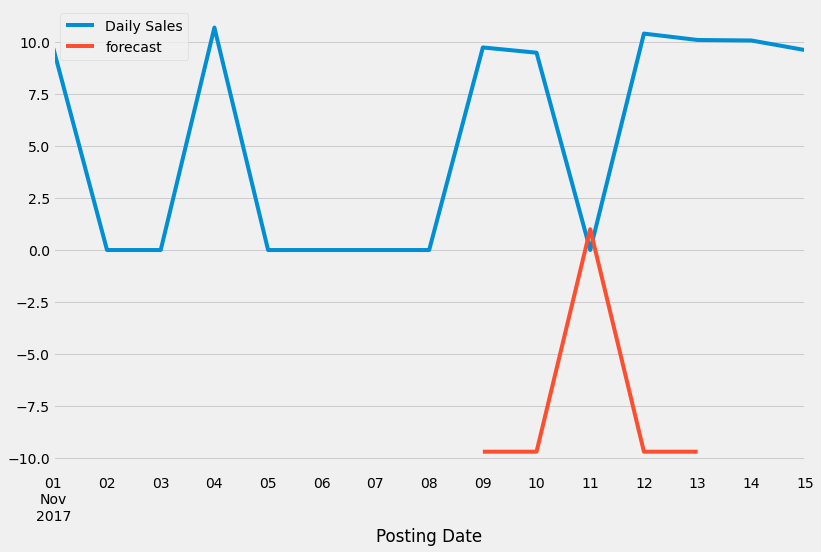

In [106]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(logy['Daily Sales'],order=(0, 1, 0),seasonal_order=(0,1,0,7))
results = model.fit()
logy['forecast']=results.predict(start=8, end=12, dynamic=True)
logy[['Daily Sales','forecast']].plot(figsize=(12,8))

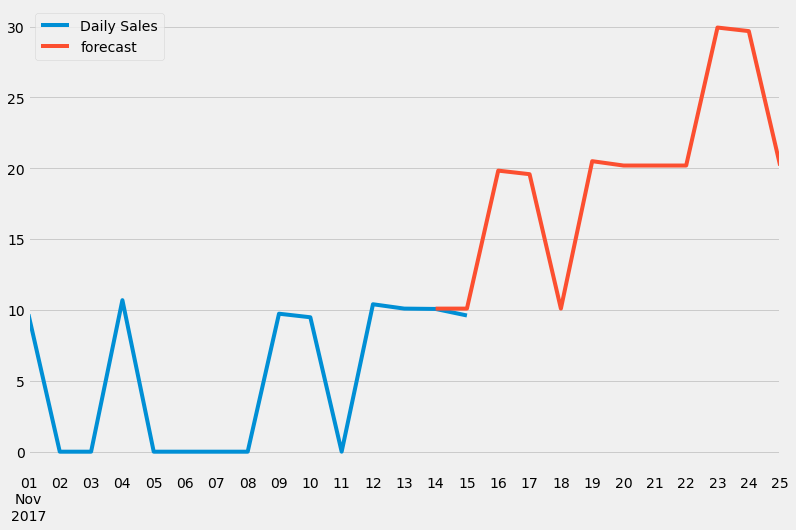

In [107]:
from pandas.tseries.offsets import DateOffset

future_dates=[logy.index[-1]+ DateOffset(days=x) for x in range(0,11)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=logy.columns)

future_datest_df.tail()

future_df=pd.concat([logy,future_datest_df])

future_df['forecast'] = results.predict(start = 13, end = 24, dynamic= True)
future_df[['Daily Sales', 'forecast']].plot(figsize=(12, 8))

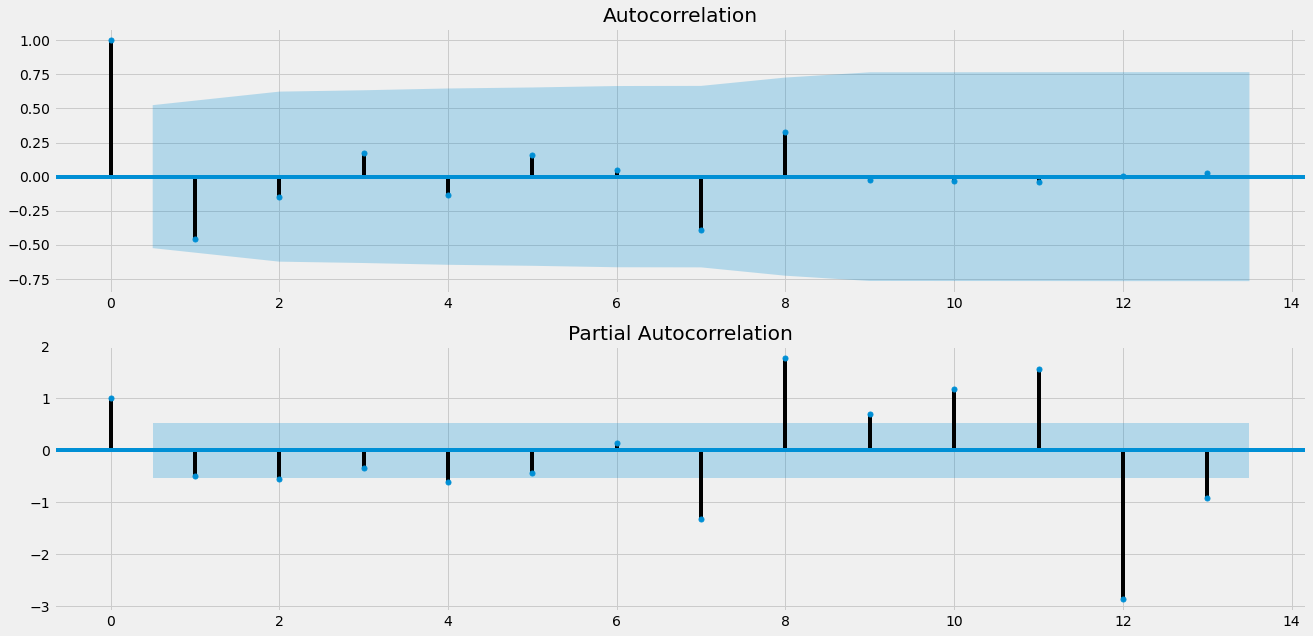

In [110]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(daily_sales_nov.diff().dropna(), lags=13
, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(daily_sales_nov.diff().dropna(), lags=13, ax=ax[1])
plt.show()

In [111]:
resDiff = sm.tsa.arma_order_select_ic(daily_sales_nov, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (0, 0) is the best.


In [112]:
arima = sm.tsa.statespace.SARIMAX(daily_sales_nov,order=(0,1,0), seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            Daily Sales   No. Observations:                   15
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -147.712
Date:                Tue, 10 May 2022   AIC                            297.424
Time:                        17:26:32   BIC                            297.989
Sample:                    11-01-2017   HQIC                           297.308
                         - 11-15-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.912e+08    1.2e+08      3.253      0.001    1.56e+08    6.27e+08
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.27
Prob(Q):                               nan   Prob(JB):                         0.87
Heteroskedasticity (H):               0.32   Skew:                             0.15
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

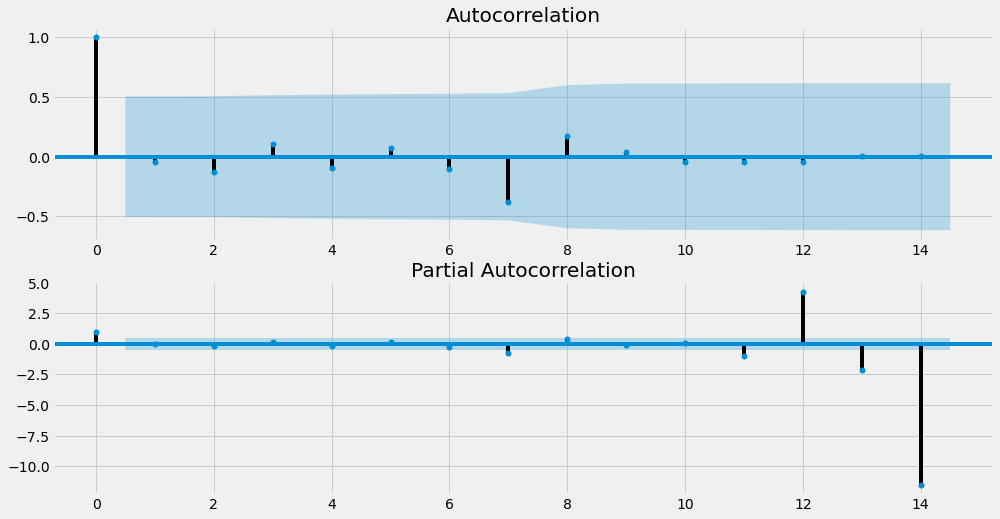

In [113]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(daily_sales_nov, lags=14, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(daily_sales_nov, lags=14, ax=ax[1])
plt.show()

In [188]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(daily_sales_nov['Daily Sales'], order=(0,1,0))
model = arima_model.fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Daily Sales   No. Observations:                   14
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -158.842
Method:                           css   S.D. of innovations          20474.057
Date:                Tue, 10 May 2022   AIC                            321.684
Time:                        17:59:55   BIC                            322.962
Sample:                    11-02-2017   HQIC                           321.566
                         - 11-15-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -90.6428   5471.922     -0.017      0.987   -1.08e+04    1.06e+04


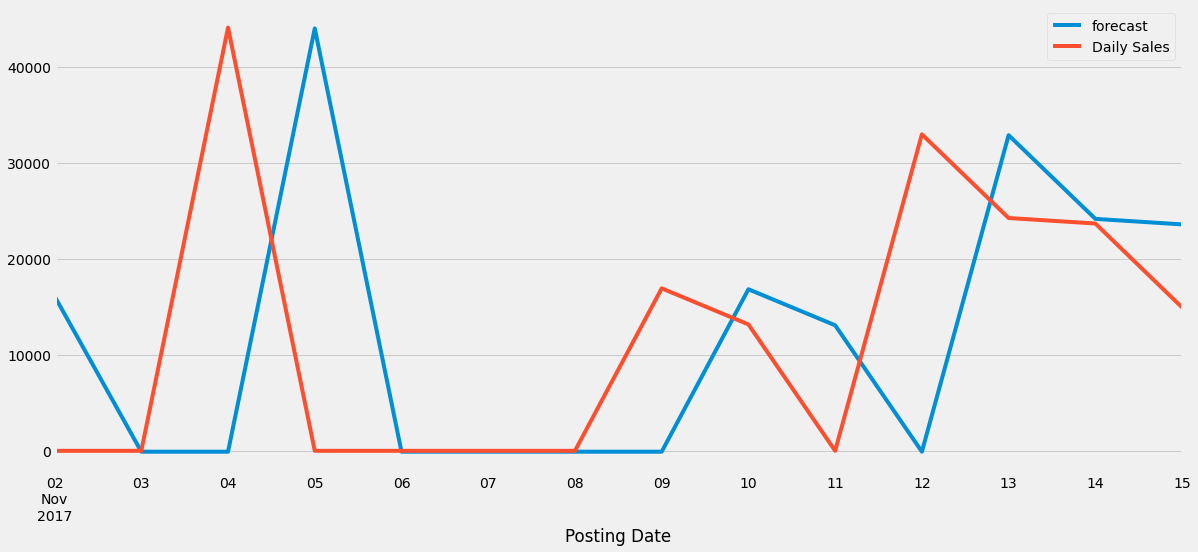

In [189]:
model.plot_predict(dynamic=False)
plt.show()

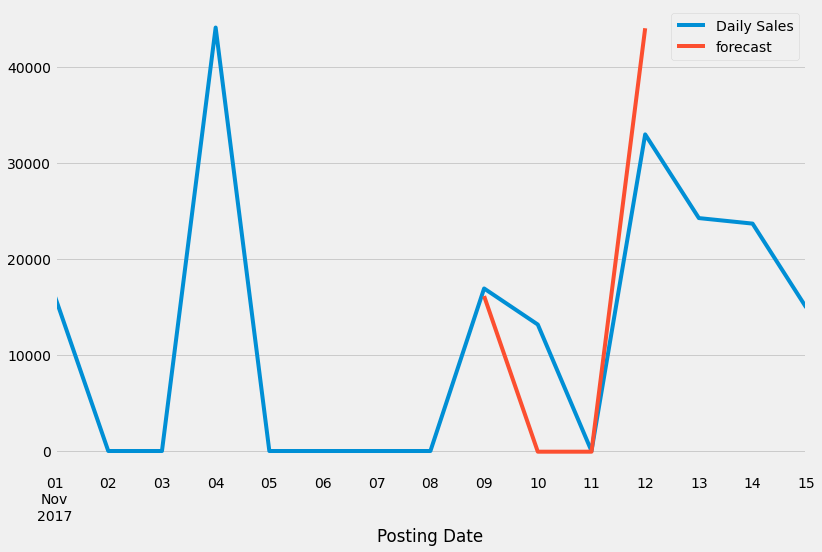

In [192]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(daily_sales_nov['Daily Sales'],order=(0, 1, 0),seasonal_order=(0, 1, 0, 8))
results=model.fit()
daily_sales_nov['forecast']=results.predict(start=8, end=11, dynamic=True)
daily_sales_nov[['Daily Sales','forecast']].plot(figsize=(12,8))

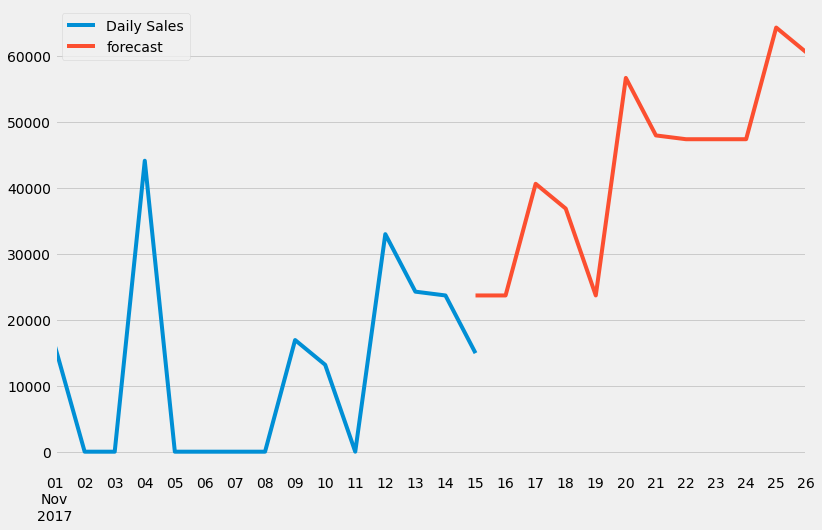

In [193]:
from pandas.tseries.offsets import DateOffset
future_dates=[daily_sales_nov.index[-1]+ DateOffset(days=x)for x in range(0,12)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=daily_sales_nov.columns)

future_datest_df.tail()

future_df=pd.concat([daily_sales_nov,future_datest_df])

future_df['forecast'] = results.predict(start = 14, end = 26, dynamic= True)
future_df[['Daily Sales', 'forecast']].plot(figsize=(12, 8))